In [1]:
 # if plotting does not work, change it into %matplotlib inline
# %matplotlib widget
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import display_array, normalise_clip
import deepdish as dd

# Load and display the data

In [3]:
fps = 3
# Change this to the folder where you have the data
data_path = r"/mnt/c/Users/Cristina/Documents/2p_nuclear/imaging.h5"
ar_imaging = dd.io.load(data_path)
display_array(ar_imaging);

interactive(children=(IntSlider(value=279, description='t', max=559), IntSlider(value=1, description='z', max=…

Creating an image of the anatomy by averaging in time

In [4]:
anatomy = np.average(ar_imaging,0)

In [5]:
# normalize the data
anatomy_normalized = normalise_clip(anatomy, wins_min=5, wins_max=99.5)

In [6]:
display_array(anatomy_normalized)

interactive(children=(IntSlider(value=1, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

<function utilities.display_array.<locals>.browse(i:(0, 2))>

Design a kernel similar to a cell for cross correlation. For indicators localised to the nucleus, a gaussian might be a good fit

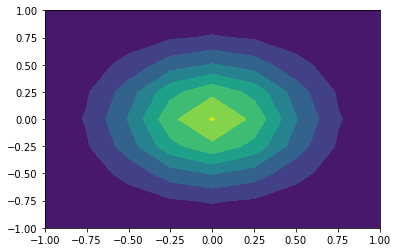

In [7]:
from scipy.stats import multivariate_normal
# x, y = np.mgrid[-1:1:.01, -1:1:.01]
x, y = np.mgrid[-1:1.25:.25, -1:1.25:.25]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
var = multivariate_normal(mean=[0, 0], cov=[[0.15, 0], [0, 0.15]])
kernel = var.pdf(pos)
plt.contourf(x, y, kernel)

Plot the kernel next to a cell that you select

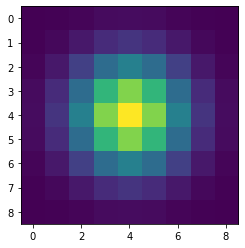

In [8]:
plt.imshow(kernel)

Convolve the kernel with the image. The correlate2d function from scipy.signal works for that

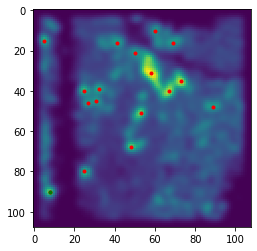

In [9]:
# using local maxima to detect potential ROIs. Have a look at the funciton documentation.
from skimage.feature import peak_local_max
from scipy.signal import correlate2d
corr = correlate2d(anatomy_normalized[1], kernel)
coordinates = peak_local_max(corr, min_distance=2,threshold_rel=0.5)

plt.imshow(corr)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.plot(coordinates[0, 1], coordinates[0, 0], 'g.')

You should get something like:

![](template_match.png)

* Try to find exactly what the parameters of the gaussian kernel should be by plotting a line profile through the middle of a cell and fitting a gaussian probability density

## Extract traces around the points

You can loop around the maxima coordinates and take a small rectangular window around it. For better results use a gaussian kernel

In [10]:
n_cells = np.shape(coordinates)[0]
n_timepoints = np.shape(ar_imaging)[0]
windows = np.zeros([n_cells,4],dtype=int)
window_size = 5
for i in range(n_cells):
    x = coordinates[i,0]
    y = coordinates[i,1]
    windows[i,:]=np.array([x-window_size, x+window_size, y-window_size,y+window_size],dtype=int)


In [11]:
# Select a plane
plane1 = ar_imaging[:,1]
print(np.shape(plane1))
display_array(plane1)

(560, 100, 100)


interactive(children=(IntSlider(value=279, description='i', max=559), Output()), _dom_classes=('widget-interac…

<function utilities.display_array.<locals>.browse(i:(0, 559))>

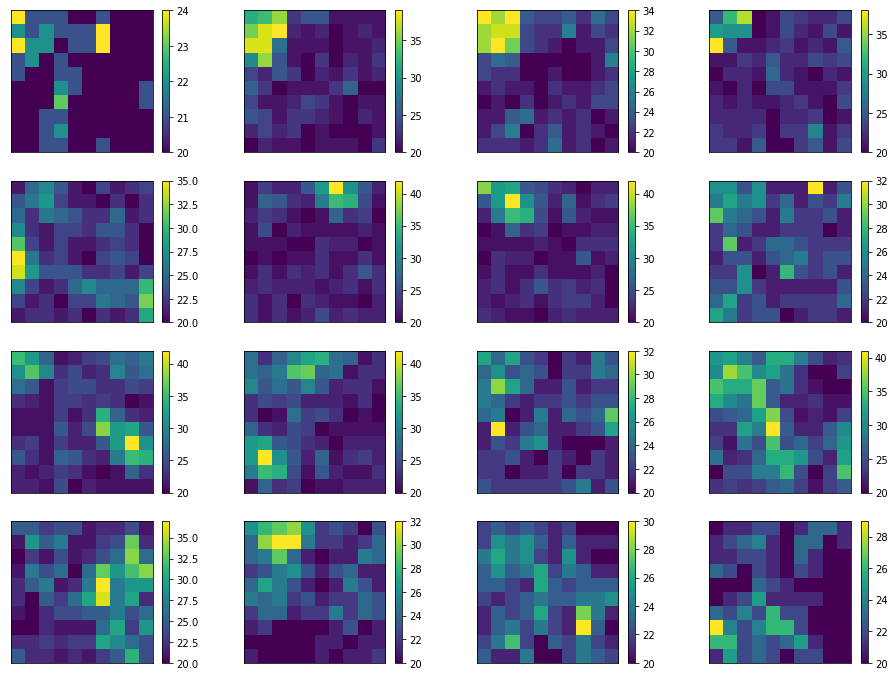

In [12]:
# Example. Print windows around the selected cells for the timepoint 107
fig = plt.figure(figsize=(16, 12))
for i in range(n_cells-1):
    y1, y2, x1, x2 = windows[i,:]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    im = ax.imshow(plane1[107,y1:y2, x1:x2])
    fig.colorbar(im)
    #print(x1, x2, y1,y2)
    
plt.show()

In [13]:
# Spatial mean across each window for all timepoints
traces = np.zeros((n_cells, n_timepoints))
for i in range(n_cells):
    y1, y2, x1, x2 = windows[i,:]
    window = plane1[:, y1:y2, x1:x2]
    avg_activity = np.mean(window, axis = (1,2))
    traces[i,:] = avg_activity

You should get an array of traces [n_cells, n_timepoints]

In [14]:
time = np.arange(traces.shape[1])/fps

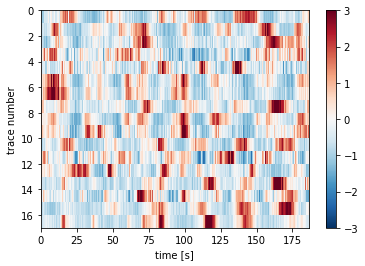

In [15]:
from scipy.stats import zscore
fig, ax = plt.subplots()
img = ax.imshow(zscore(traces, 1), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r", extent=(0, time[-1], traces.shape[0], 0))
ax.set_xlabel("time [s]")
ax.set_ylabel("trace number")
fig.colorbar(img)

In [16]:
fig.savefig("traces_anat_1_cris.png")

The result should look a bit like this:

![](traces_anat_1.png)

Use ipywidgets interact to browse through the individual traces

In [17]:
from ipywidgets import interact

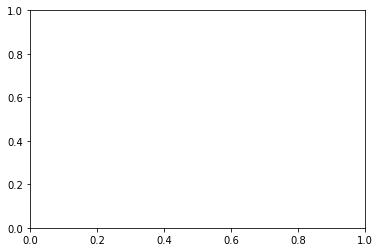

interactive(children=(IntSlider(value=8, description='i_trace', max=16), Output()), _dom_classes=('widget-inte…

In [18]:
fig, ax = plt.subplots()
@interact
def browse_trace(i_trace:(0, traces.shape[0]-1)):
    ax.clear()
    ax.plot(time, traces[i_trace])

# Eigencells

We have extracted cells using a gaussian kernel, but what is the actual shape of cells?

Collect areas around "cells" selected by local maxima in the previous procedure (or find a way to manually annotate a part of the dataset)

Apply principal component analysis on the reshaped images (have at least 50, then you should have a matrix 50 x total number of pixels) and display their shapes

Use the eigncells to detect more cells in the dataset